In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
import rdflib
from rdflib.extras.external_graph_libs import rdflib_to_networkx_digraph

filename = "cleaned_maingraph.nt"
g = rdflib.Graph()
g.parse(filename, format="nt")
print("rdflib Graph loaded successfully")
G = rdflib_to_networkx_digraph(g)
print("networkx Graph loaded successfully")

rdflib Graph loaded successfully
networkx Graph loaded successfully


In [6]:
# SPARQL query to count the number of each type of predicate
query = """
SELECT ?predicate (COUNT(?predicate) AS ?count)
WHERE {
  ?subject ?predicate ?object .
}
GROUP BY ?predicate
"""

# Execute the query
results = g.query(query)

for row in results:
    predicate = str(row[0])
    count = int(row[1])
    print(f"{predicate}: {count}")

http://edamontology.org/data_2082: 537092
http://edamontology.org/has_output: 1611415
http://edamontology.org/data_3754: 809977
http://identifiers.org/ensembl/id: 214599
https://w3id.org/biolink/vocab/Gene: 117672
https://w3id.org/biolink/vocab/symbol: 6835
http://purl.org/dc/terms/identifier: 30
http://purl.org/dc/terms/publisher: 30
http://www.w3.org/1999/02/22-rdf-syntax-ns#type: 13
http://purl.org/dc/terms/date: 30
http://purl.org/dc/terms/title: 30


In [7]:
# SPARQL query to count distinct subjects grouped by their prefixes or urn:uuid:
subject_query = """
SELECT (COUNT(DISTINCT ?subject) AS ?count) ?prefix
WHERE {
  ?subject ?predicate ?object .
  BIND(IF(STRSTARTS(STR(?subject), "urn:uuid:"), "urn:uuid:", STRBEFORE(STR(?subject), ":")) AS ?prefix)
}
GROUP BY ?prefix
ORDER BY ?prefix
"""

# SPARQL query to count distinct objects grouped by their prefixes or urn:uuid:
object_query = """
SELECT (COUNT(DISTINCT ?object) AS ?count) ?prefix
WHERE {
  ?subject ?predicate ?object .
  BIND(IF(STRSTARTS(STR(?object), "urn:uuid:"), "urn:uuid:", STRBEFORE(STR(?object), ":")) AS ?prefix)
}
GROUP BY ?prefix
ORDER BY ?prefix
"""

# Execute the subject query
subject_results = g.query(subject_query)

# Execute the object query
object_results = g.query(object_query)

# Print the subject results
print("Subjects grouped by prefixes or urn:uuid:")
for row in subject_results:
    prefix = str(row[1])
    count = int(row[0])
    print(f"{prefix}: {count}")

# Print the object results
print("\nObjects grouped by prefixes or urn:uuid:")
for row in object_results:
    prefix = str(row[1])
    count = int(row[0])
    print(f"{prefix}: {count}")

KeyboardInterrupt: 

In [28]:
from rdflib import URIRef, Literal, XSD

log_fold_change_predicate = URIRef("http://edamontology.org/data_3754")
p_value_predicate = URIRef("http://edamontology.org/data_2082")
gene_predicate = URIRef("https://w3id.org/biolink/vocab/Gene")  

data = []
gene_ids = []


for subject in g.subjects():
    # Extract gene
    gene = g.value(subject=subject, predicate=gene_predicate)
    if gene:
        # Extract log fold change
        log_fold_change_literal = g.value(subject=subject, predicate=log_fold_change_predicate)
        if log_fold_change_literal and log_fold_change_literal.datatype == XSD.double:
            try:
                log_fold_change = float(log_fold_change_literal)
            except ValueError:
                log_fold_change = None
        else:
            log_fold_change = None

        # Extract p-value
        p_value_literal = g.value(subject=subject, predicate=p_value_predicate)
        if p_value_literal and p_value_literal.datatype == XSD.double:
            try:
                p_value = float(p_value_literal)
            except ValueError:
                p_value = None
        else:
            p_value = None

        # Append to data only if log fold change is not 0 and both values are not None
        if log_fold_change is not None and p_value is not None and log_fold_change != 0:
            data.append([log_fold_change, p_value])
            gene_ids.append(str(gene))

# Convert data to numpy array and check the shape
X = np.array(data)

if X.size == 0:
    raise ValueError("No valid data found")

if X.ndim == 1:
    X = X.reshape(-1, 2)  # Reshape to 2D array if it's incorrectly shaped

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled data:", X_scaled)
print("Gene IDs:", gene_ids)

Scaled data: [[-0.1138939   0.72863651]
 [-0.58868997 -0.58966219]
 [-0.25823188 -0.58966219]
 ...
 [ 0.39399641 -0.58821492]
 [-0.21999844 -0.58966219]
 [-0.3027694   0.70889667]]
Gene IDs: ['https://monarchinitiative.org/HGNC:33887', 'https://monarchinitiative.org/HGNC:15634', 'https://monarchinitiative.org/HGNC:22917', 'https://monarchinitiative.org/HGNC:8855', 'https://monarchinitiative.org/HGNC:56650', 'https://monarchinitiative.org/HGNC:26999', 'https://monarchinitiative.org/HGNC:16508', 'https://monarchinitiative.org/HGNC:24955', 'https://monarchinitiative.org/HGNC:11843', 'https://monarchinitiative.org/HGNC:25213', 'https://monarchinitiative.org/HGNC:4248', 'https://monarchinitiative.org/HGNC:8912', 'https://monarchinitiative.org/HGNC:3070', 'https://monarchinitiative.org/HGNC:9650', 'https://monarchinitiative.org/HGNC:10765', 'https://monarchinitiative.org/HGNC:7132', 'https://monarchinitiative.org/HGNC:7554', 'https://monarchinitiative.org/HGNC:2715', 'https://monarchinitiati

In [29]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['gene_id'] = gene_ids

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1} explains {ratio:.2%} of the variance")
print(f"\nCumulative explained variance ratio: {cumulative_variance_ratio[-1]:.2%}")

PC1 explains 55.32% of the variance
PC2 explains 44.68% of the variance

Cumulative explained variance ratio: 100.00%


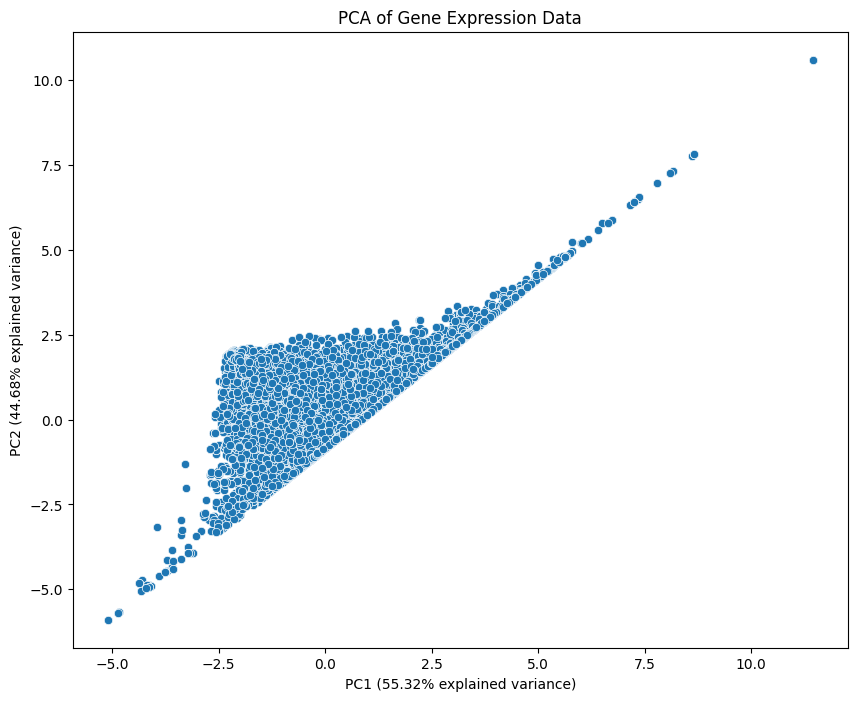

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2')
plt.title('PCA of Gene Expression Data')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.2%} explained variance)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.2%} explained variance)')
plt.show()

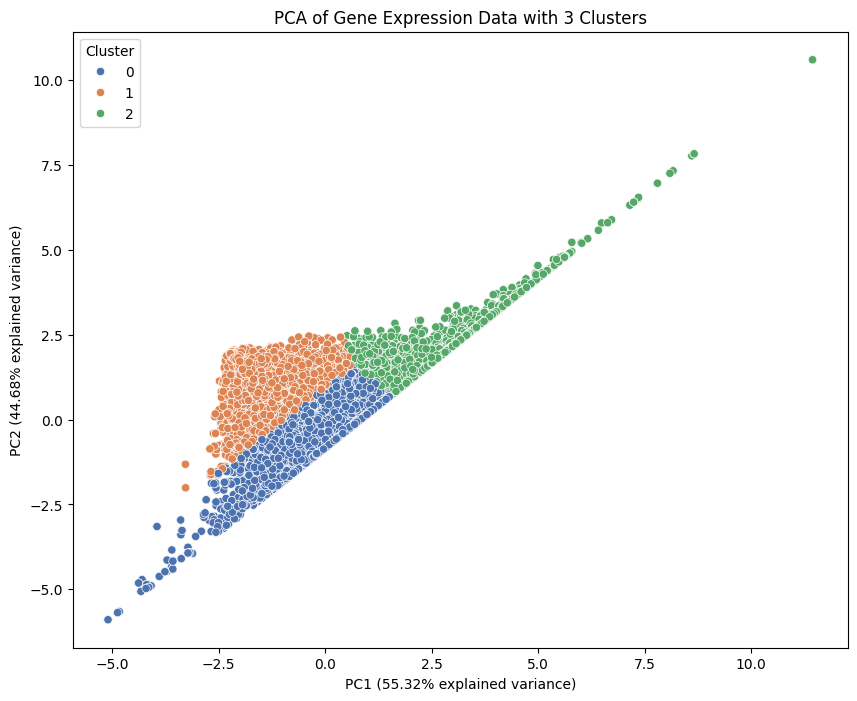

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine optimal number of clusters
silhouette_scores = []
max_clusters = 10  # Adjust based on your data and domain knowledge
for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca[:, :2])  # Using first 2 PCs
    silhouette_scores.append(silhouette_score(X_pca[:, :2], cluster_labels))

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

# Apply K-means with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(X_pca[:, :2])

# Visualize clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='deep')
plt.title(f'PCA of Gene Expression Data with {optimal_clusters} Clusters')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.2%} explained variance)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.2%} explained variance)')
plt.show()

In [31]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=['Log Fold Change', 'P-value']
)
print("Component Loadings:")
print(loadings)

print("Column names in pca_df:")
print(pca_df.columns)

Component Loadings:
                      PC1       PC2
Log Fold Change  0.707107  0.707107
P-value         -0.707107  0.707107
Column names in pca_df:
Index(['PC1', 'PC2', 'gene_id'], dtype='object')


Top significant genes:
                                         gene_id  Original Log Fold Change  \
14681    https://monarchinitiative.org/HGNC:6544                 -0.852559   
26762    https://monarchinitiative.org/HGNC:6544                 -0.852559   
177274   https://monarchinitiative.org/HGNC:6544                 -0.852559   
1358     https://monarchinitiative.org/HGNC:2602                 -0.697685   
31871    https://monarchinitiative.org/HGNC:2602                 -0.697685   
...                                          ...                       ...   
121271  https://monarchinitiative.org/HGNC:14870                 -0.588215   
134314  https://monarchinitiative.org/HGNC:14870                 -0.588215   
45038     https://monarchinitiative.org/HGNC:101                 -0.578140   
88596     https://monarchinitiative.org/HGNC:101                 -0.578140   
115557    https://monarchinitiative.org/HGNC:101                 -0.578140   

        Original P-value       PC1      

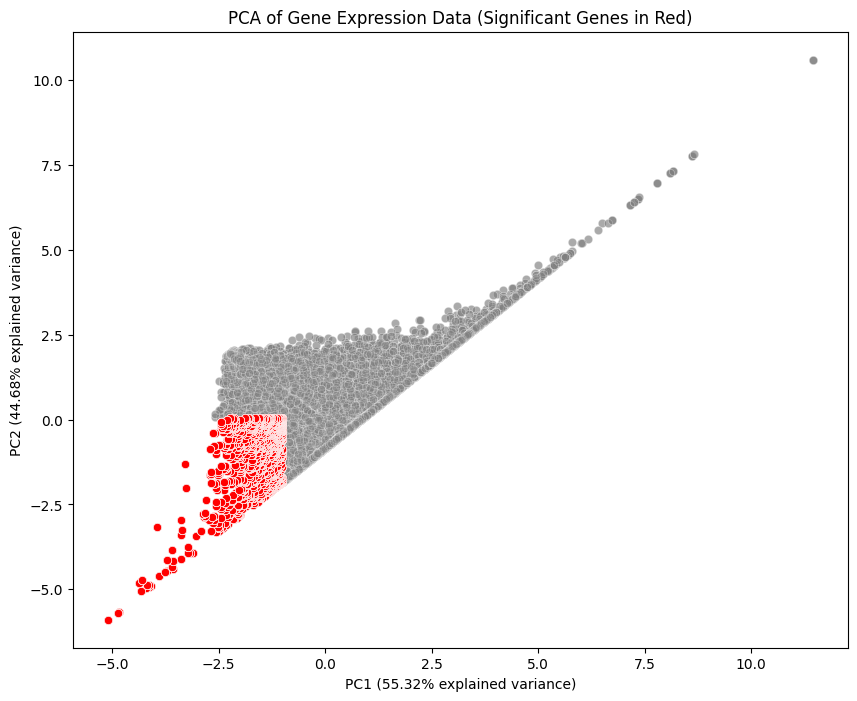


Distribution of significant genes across PC quadrants:
PC2_direction  Negative  Positive
PC1_direction                    
Negative           3045       153


In [32]:
# Identify genes with significant changes
def is_significant(row, p_value_threshold=0.05, log_fold_change_threshold=1):
    p_value = row['PC2']
    log_fold_change = row['PC1']
    return (p_value < p_value_threshold) and (abs(log_fold_change) > log_fold_change_threshold)

# Add original (unscaled) values to the dataframe
pca_df['Original Log Fold Change'] = X[:, 0]  # Assuming the first column is log fold change
pca_df['Original P-value'] = X[:, 1]  # Assuming the second column is p-value

# Identify significant genes
significant_genes = pca_df[pca_df.apply(is_significant, axis=1)]

# Sort by p-value (ascending) and absolute log fold change (descending)
significant_genes = significant_genes.sort_values(
    by=['Original P-value', 'Original Log Fold Change'],
    ascending=[True, False]
)

print("Top significant genes:")
print(significant_genes[['gene_id', 'Original Log Fold Change', 'Original P-value', 'PC1', 'PC2']])

# Visualize significant genes in PC space
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', alpha=0.3, color='gray')
sns.scatterplot(data=significant_genes, x='PC1', y='PC2', color='red')
plt.title('PCA of Gene Expression Data (Significant Genes in Red)')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.2%} explained variance)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.2%} explained variance)')
plt.show()

# Analyze distribution of significant genes across PC quadrants
significant_genes['PC1_direction'] = significant_genes['PC1'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
significant_genes['PC2_direction'] = significant_genes['PC2'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
quadrant_distribution = significant_genes.groupby(['PC1_direction', 'PC2_direction']).size().unstack()
print("\nDistribution of significant genes across PC quadrants:")
print(quadrant_distribution)

Column names:
Index(['PC1', 'PC2', 'gene_id', 'Original Log Fold Change',
       'Original P-value'],
      dtype='object')


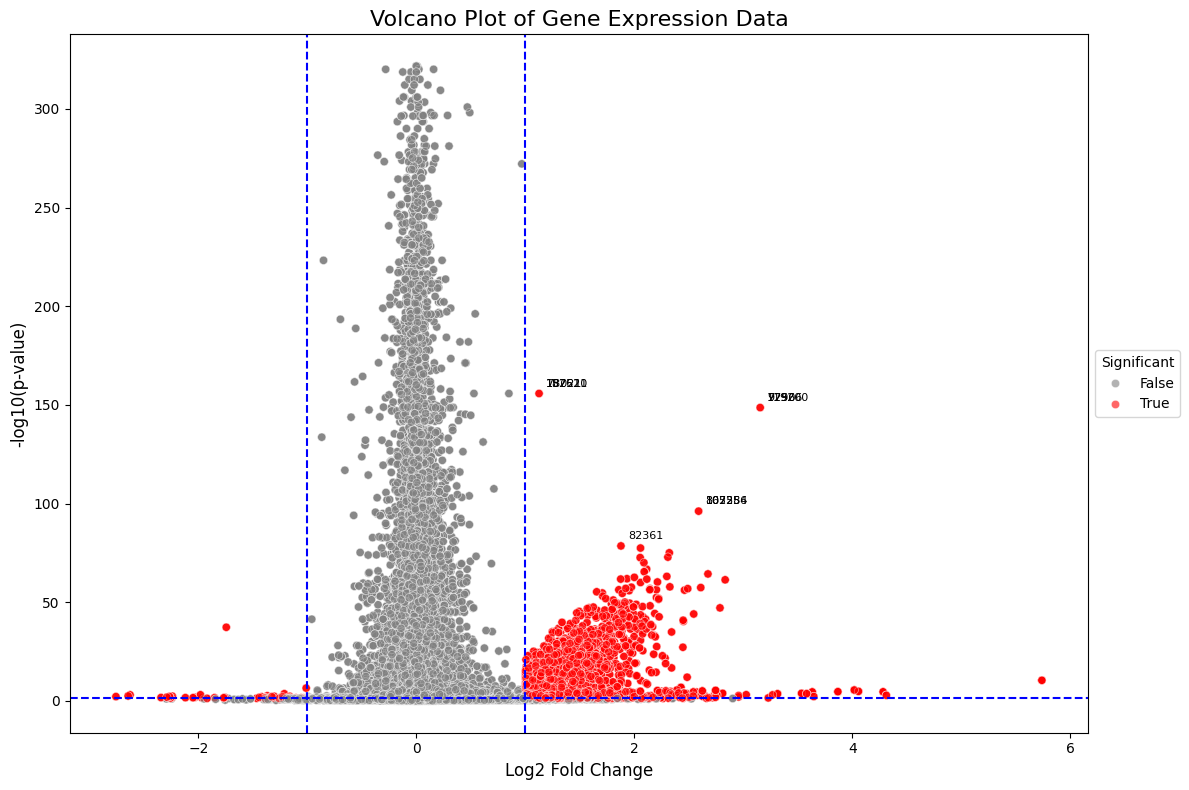

Number of significant genes: 8649 out of 199068 total genes
Percentage of significant genes: 4.34%

Top 10 most significant genes:
                                         gene_id  Original Log Fold Change  \
78021    https://monarchinitiative.org/HGNC:5998                  1.125322   
152521   https://monarchinitiative.org/HGNC:5998                  1.125322   
187610   https://monarchinitiative.org/HGNC:5998                  1.125322   
9290    https://monarchinitiative.org/HGNC:16142                  3.154306   
77566   https://monarchinitiative.org/HGNC:16142                  3.154306   
119200  https://monarchinitiative.org/HGNC:16142                  3.154306   
86258   https://monarchinitiative.org/HGNC:16838                  2.589386   
105256  https://monarchinitiative.org/HGNC:16838                  2.589386   
107254  https://monarchinitiative.org/HGNC:16838                  2.589386   
82361   https://monarchinitiative.org/HGNC:10080                  1.876817   

        Or

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Ensure we have the correct column names
print("Column names:")
print(pca_df.columns)

# Replace these with your actual column names if different
log_fold_change_col = 'Original Log Fold Change'
p_value_col = 'Original P-value'

# Create a new DataFrame for the plot
volcano_df = pca_df.copy()

# Calculate -log10(p-value)
volcano_df['-log10(p-value)'] = -np.log10(volcano_df[p_value_col])

# Define significance thresholds
p_value_threshold = 0.05
log_fold_change_threshold = 1  # This is the absolute value threshold

# Create a new column for color coding
volcano_df['Significant'] = (
    (volcano_df[p_value_col] < p_value_threshold) & 
    (abs(volcano_df[log_fold_change_col]) > log_fold_change_threshold)
)

# Create the volcano plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=volcano_df,
    x=log_fold_change_col,
    y='-log10(p-value)',
    hue='Significant',
    palette={True: 'red', False: 'grey'},
    alpha=0.6
)

# Add lines for thresholds
plt.axhline(-np.log10(p_value_threshold), color='blue', linestyle='--')
plt.axvline(-log_fold_change_threshold, color='blue', linestyle='--')
plt.axvline(log_fold_change_threshold, color='blue', linestyle='--')

# Customize the plot
plt.title('Volcano Plot of Gene Expression Data', fontsize=16)
plt.xlabel('Log2 Fold Change', fontsize=12)
plt.ylabel('-log10(p-value)', fontsize=12)

# Add labels for some of the most significant points
top_genes = volcano_df[volcano_df['Significant']].nlargest(10, '-log10(p-value)')
for idx, row in top_genes.iterrows():
    plt.annotate(row.name, (row[log_fold_change_col], row['-log10(p-value)']), 
                 xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.legend(title='Significant', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Print summary
significant_count = volcano_df['Significant'].sum()
total_count = len(volcano_df)
print(f"Number of significant genes: {significant_count} out of {total_count} total genes")
print(f"Percentage of significant genes: {significant_count/total_count:.2%}")

# List top significant genes
print("\nTop 10 most significant genes:")
print(top_genes[['gene_id', log_fold_change_col, p_value_col, '-log10(p-value)']])

Column names:
Index(['PC1', 'PC2', 'gene_id', 'Original Log Fold Change',
       'Original P-value'],
      dtype='object')


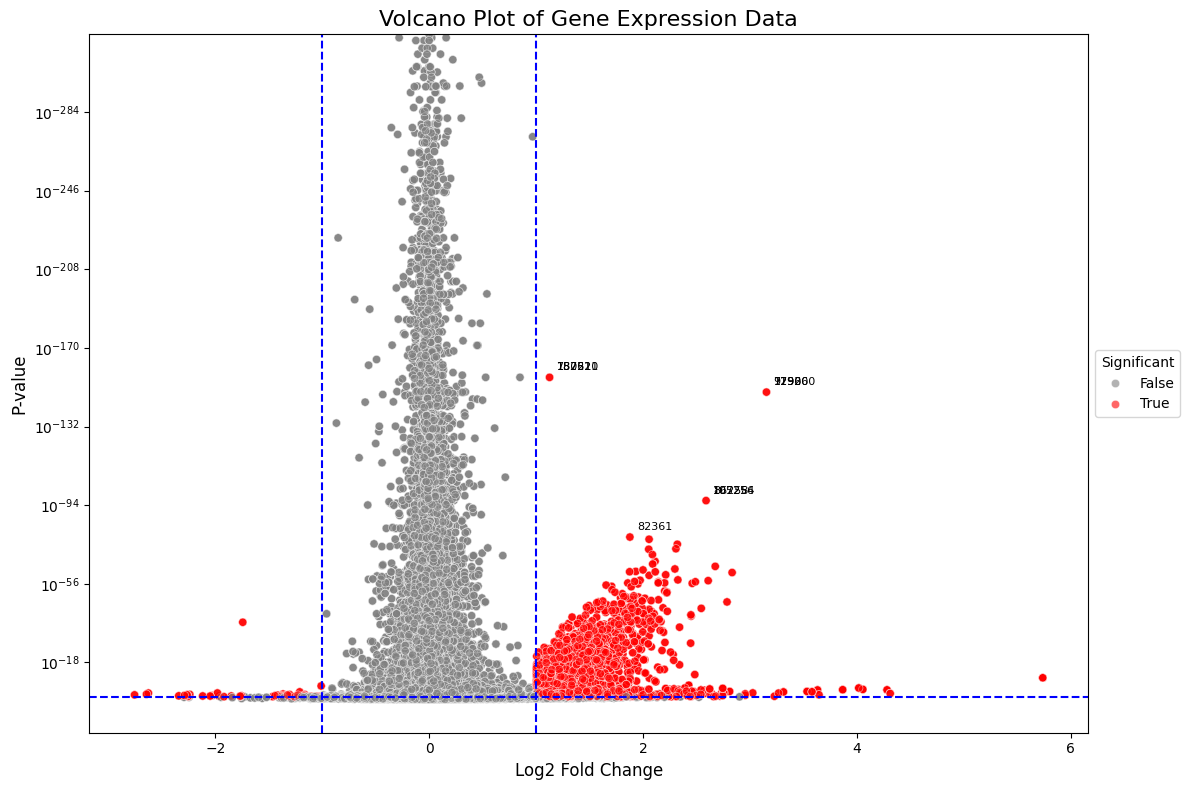

Number of significant genes: 8649 out of 199068 total genes
Percentage of significant genes: 4.34%

Top 10 most significant genes:
                                         gene_id  Original Log Fold Change  \
78021    https://monarchinitiative.org/HGNC:5998                  1.125322   
152521   https://monarchinitiative.org/HGNC:5998                  1.125322   
187610   https://monarchinitiative.org/HGNC:5998                  1.125322   
9290    https://monarchinitiative.org/HGNC:16142                  3.154306   
77566   https://monarchinitiative.org/HGNC:16142                  3.154306   
119200  https://monarchinitiative.org/HGNC:16142                  3.154306   
86258   https://monarchinitiative.org/HGNC:16838                  2.589386   
105256  https://monarchinitiative.org/HGNC:16838                  2.589386   
107254  https://monarchinitiative.org/HGNC:16838                  2.589386   
82361   https://monarchinitiative.org/HGNC:10080                  1.876817   

        Or

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Ensure we have the correct column names
print("Column names:")
print(pca_df.columns)

# Replace these with your actual column names if different
log_fold_change_col = 'Original Log Fold Change'
p_value_col = 'Original P-value'

# Create a new DataFrame for the plot
volcano_df = pca_df.copy()

# Define significance thresholds
p_value_threshold = 0.05
log_fold_change_threshold = 1  # This is the absolute value threshold

# Create a new column for color coding
volcano_df['Significant'] = (
    (volcano_df[p_value_col] < p_value_threshold) & 
    (abs(volcano_df[log_fold_change_col]) > log_fold_change_threshold)
)

# Create the volcano plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=volcano_df,
    x=log_fold_change_col,
    y=p_value_col,
    hue='Significant',
    palette={True: 'red', False: 'grey'},
    alpha=0.6
)

# Add lines for thresholds
plt.axhline(p_value_threshold, color='blue', linestyle='--')
plt.axvline(-log_fold_change_threshold, color='blue', linestyle='--')
plt.axvline(log_fold_change_threshold, color='blue', linestyle='--')

# Customize the plot
plt.title('Volcano Plot of Gene Expression Data', fontsize=16)
plt.xlabel('Log2 Fold Change', fontsize=12)
plt.ylabel('P-value', fontsize=12)

# Set y-axis to log scale
plt.yscale('log')
plt.gca().invert_yaxis()  # Invert y-axis so smaller p-values are at the top

# Add labels for some of the most significant points
top_genes = volcano_df[volcano_df['Significant']].nsmallest(10, p_value_col)
for idx, row in top_genes.iterrows():
    plt.annotate(row.name, (row[log_fold_change_col], row[p_value_col]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.legend(title='Significant', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Print summary
significant_count = volcano_df['Significant'].sum()
total_count = len(volcano_df)
print(f"Number of significant genes: {significant_count} out of {total_count} total genes")
print(f"Percentage of significant genes: {significant_count/total_count:.2%}")

# List top significant genes
print("\nTop 10 most significant genes:")
print(top_genes[['gene_id', log_fold_change_col, p_value_col]])

In [41]:

query = """
    SELECT DISTINCT ?p 
    WHERE {
        ?s ?p ?o
    }
"""

results = g.query(query)
for row in results:
    p = str(row.p) if isinstance(row.p, (Literal, URIRef)) else row.p
    print(p)


http://edamontology.org/data_3754
http://edamontology.org/has_output
http://edamontology.org/data_2082
http://identifiers.org/ensembl/id
https://w3id.org/biolink/vocab/Gene
https://w3id.org/biolink/vocab/symbol
http://purl.org/dc/terms/date
http://purl.org/dc/terms/title
http://purl.org/dc/terms/identifier
http://purl.org/dc/terms/publisher
http://www.w3.org/1999/02/22-rdf-syntax-ns#type
